# Predictive Modeling of Employee Attrition

## Loading libraries

In [145]:
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)

## Introduction

The relationship between employees and employers is symbiotic, both relying on each other to fulfill their goals. Thus, employee turnover is an essential factor for both prospective employees seeking career options, and for HR departments of a firm. Prospective workers can use this metric to assess the quality of life in a position, whereas, hiring managers can utilize this to improve work conditions to ensure retainment. **Employee turnover is classically defined as an employee’s “voluntary” severance of his or her current employment ties** (Mobley, 1982; Hom et al., 2019). The Hom et al. study goes further classifying voluntary as all reasons other than dismissals, layoffs, or retirement since employee turnover involves individual choice (Hom et al., 2019).

In this report, we wish to analyze the factors influencing whether an employee leaves a company, and develop a predictive logistic regression model. The dataset to perform analysis on was obtained from **kaggle.com**. It contains $4653$ observations in total with each observation corresponding to an employee. There were $9$ variables, each being details about an employee, with the last variable `LeaveOrNot` representing whether the employee leaves the company. 

A brief description of the dataset is given below: 
<br>


Variable | Type | Categorical vs Numerical | Description
---|---|---|---
`Education` | *chr* | **Categorical Variable** | The employee's educational qualifications
`JoiningYear` | *dbl* | **Numerical Variable** | The year the employee joined the company
`City` | *chr* | **Categorical Variable** | The city where the employee is based
`PaymentTier` | *dbl* | **Categorical Variable** | The salary of the employee, catagorized into various tiers
`Age` | *dbl* | **Numerical Variable** | The employee's age
`Gender` | *chr* | **Categorical Variable** | The employee's gender
`EverBenched` | *chr* | **Categorical Variable** | Flag indicating whether the employee has been benched (temporarily without assigned work)
`ExperienceInCurrentDomain` | *dbl* | **Numerical Variable** | The employee's years of experience in their respective industry
`LeaveOrNot` | *dbl* | **Categorical Variable** | Flag indicating whether the employee left the company

*Table 1* Variables Description

<br>Each group member analyzed a type of variable selection/ shrinkage technique individually and compared results. Throughout the course of this project, we wished to **predict whether an employee stays at or leaves a company depending on various other factors relating to them such as their** `Education`, `JoiningYear`, `City`, `PaymentTier`, `Age`, `Gender`, `EverBenched`, and `ExperienceInCurrentDomain`. 

Past studies have attempted to provide insight into the factors which influence employee turnover. Khatri & Budhwar’s study regarding Singaporean industries looked into age and education level, stating that "there was not much evidence for the belief that younger and more educated Singaporeans have a greater intention to leave" (Khatri & Budhwar, 2001). Another study investigated whether an employee’s retention is related with their experience, and concluded that employee retention and company experience were associated (Chatzipetrou et al., 2018).

## Method and Results
### Explatory Data Analysis

Let us load the dataset

In [146]:
employee <- read_csv('https://raw.githubusercontent.com/joelbonnie/stat301/main/Employee.csv')
# Tidying the dataset
employee_data = na.omit(employee)
employee_data_vis <- employee_data

#Number of data point after cleaning
nrow(employee_data_vis)

#Since LeaveOrNot variable only have 2 value of 0 and 1 representing whether the Employee want to leave or not, we will transform the data into discrete for visualization
employee_data_vis$LeaveOrNot <- as.factor(employee_data_vis$LeaveOrNot)
employee_data_vis$PaymentTier <- as.factor(employee_data_vis$PaymentTier)
head(employee_data_vis)

Rows: 4653 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 4653

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<fct>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


In [156]:
#Proportion of employee wanting to leave and not wanting to leave
# Summarizing the data frame
leaveornot_summary <- employee_data |>
                     group_by(LeaveOrNot) |>
                     summarize(n = n()) |>
                     mutate(Percentage = (n / sum(n)) * 100)
leaveornot_summary

LeaveOrNot,n,Percentage
<dbl>,<int>,<dbl>
0,3053,65.61358
1,1600,34.38642


Table 2: Proportion summary of people wanting to leave and not in the dataset

`summarise()` has grouped output by 'EverBenched'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'City'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Education'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PaymentTier'. You can override using the
`.groups` argument.


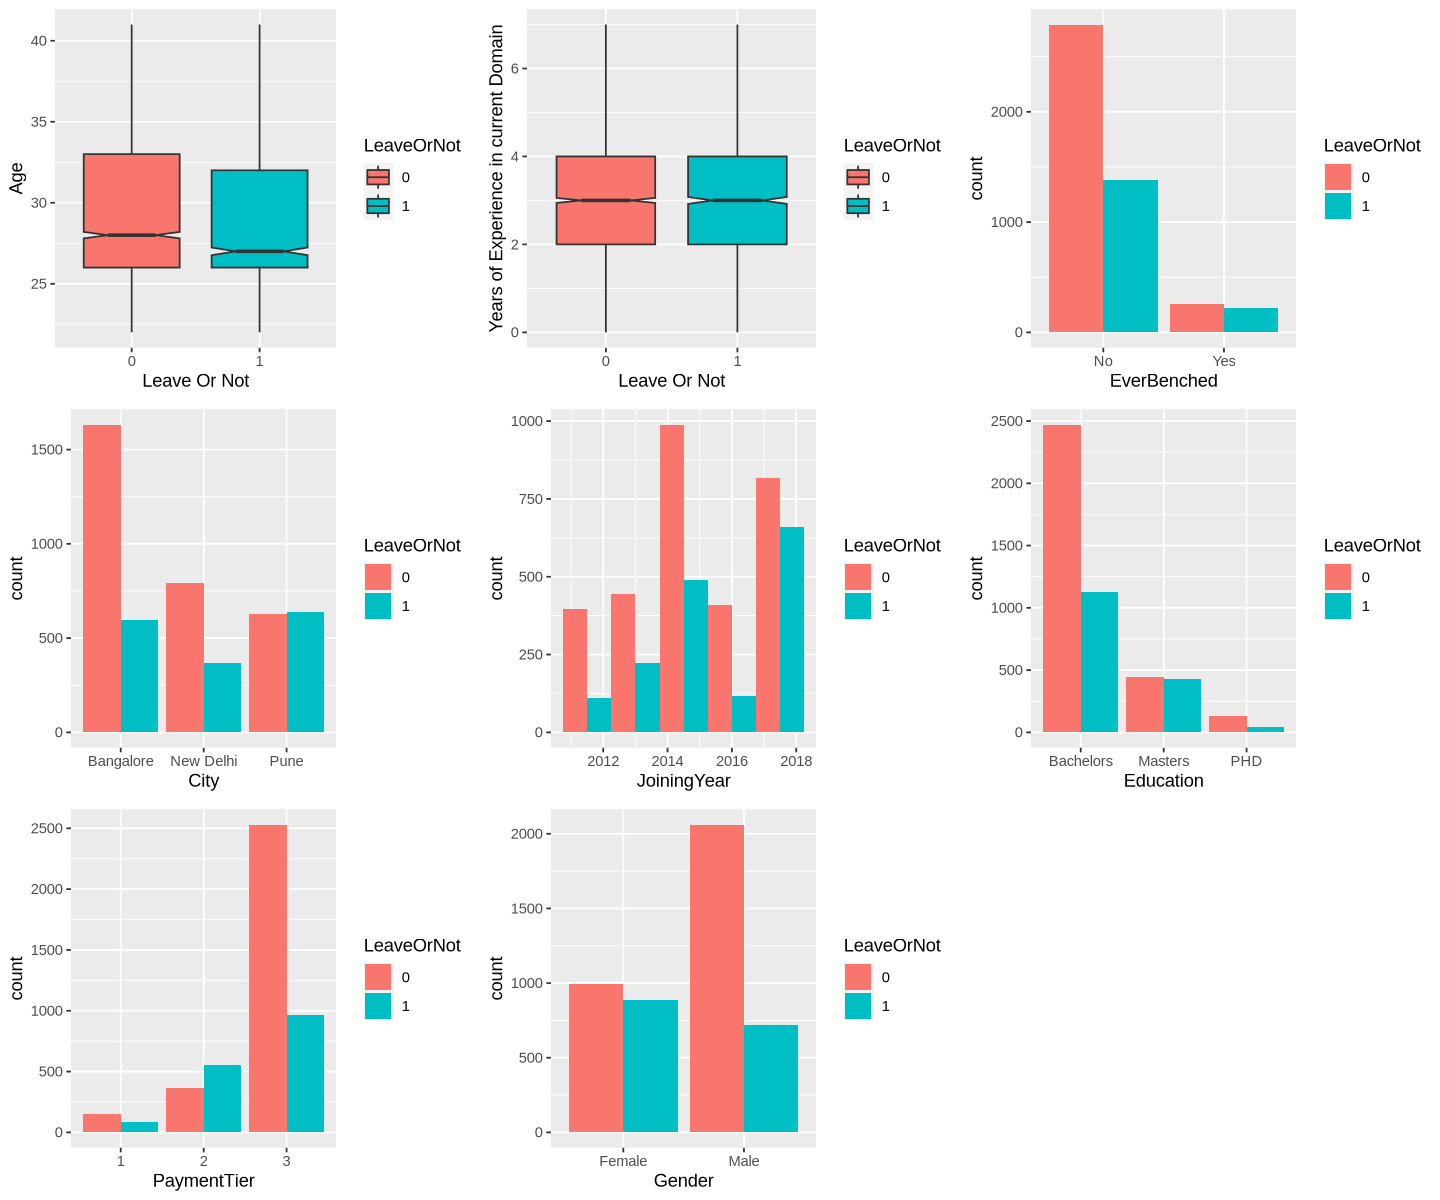

In [147]:
options(repr.plot.width = 12, repr.plot.height = 10)
age_retain <- employee_data_vis %>%
              ggplot(aes(x = LeaveOrNot, y = Age , fill = LeaveOrNot)) +
              geom_boxplot(notch = TRUE) +
              labs( x = "Leave Or Not",
                    y = "Age")

experience_retain <- employee_data_vis %>%
              ggplot(aes(y = ExperienceInCurrentDomain, x = LeaveOrNot, fill = LeaveOrNot)) +
              geom_boxplot(notch = TRUE) +
              labs( y = "Years of Experience in current Domain",
                    x = "Leave Or Not")

benched <- employee_data_vis %>%
           group_by(EverBenched, LeaveOrNot) %>%
           summarize( count = n()) %>%
           ggplot(aes(x = EverBenched, y = count, fill = LeaveOrNot)) +
           geom_bar(stat = "identity", position = "dodge")

city <- employee_data_vis %>%
           group_by(City, LeaveOrNot) %>%
           summarize( count = n()) %>%
           ggplot(aes(x = City, y = count, fill = LeaveOrNot)) +
           geom_bar(stat = "identity", position = "dodge")

joinyear <- employee_data_vis %>%
           ggplot(aes(x = JoiningYear, fill = LeaveOrNot)) +
           geom_histogram(bins = 5, position = "dodge")

education <- employee_data_vis %>%
           group_by(Education, LeaveOrNot) %>%
           summarize( count = n()) %>%
           ggplot(aes(x = Education, y = count, fill = LeaveOrNot)) +
           geom_bar(stat = "identity", position = "dodge")

payment <- employee_data_vis %>%
           group_by(PaymentTier, LeaveOrNot) %>%
           summarize( count = n()) %>%
           ggplot(aes(x = PaymentTier, y = count, fill = LeaveOrNot)) +
           geom_bar(stat = "identity", position = "dodge")

gender <- employee_data_vis %>%
          ggplot(aes(Gender,after_stat(count)))+
          geom_bar(aes(fill = LeaveOrNot), position = "dodge")

summary_plot <- plot_grid( age_retain, 
                                   experience_retain, 
                                   benched,
                                   city,
                                   joinyear,
                                   education,
                                   payment,
                                   gender,
                                   ncol = 3, nrow = 3) +
                ggtitle("Relationship of variables with LeaveOrNot variable")

summary_plot

*Image 1* Response variable relationship with other explanatory variable

`summarise()` has grouped output by 'PaymentTier', 'JoiningYear'. You can
override using the `.groups` argument.
Notch went outside hinges
ℹ Do you want `notch = FALSE`?


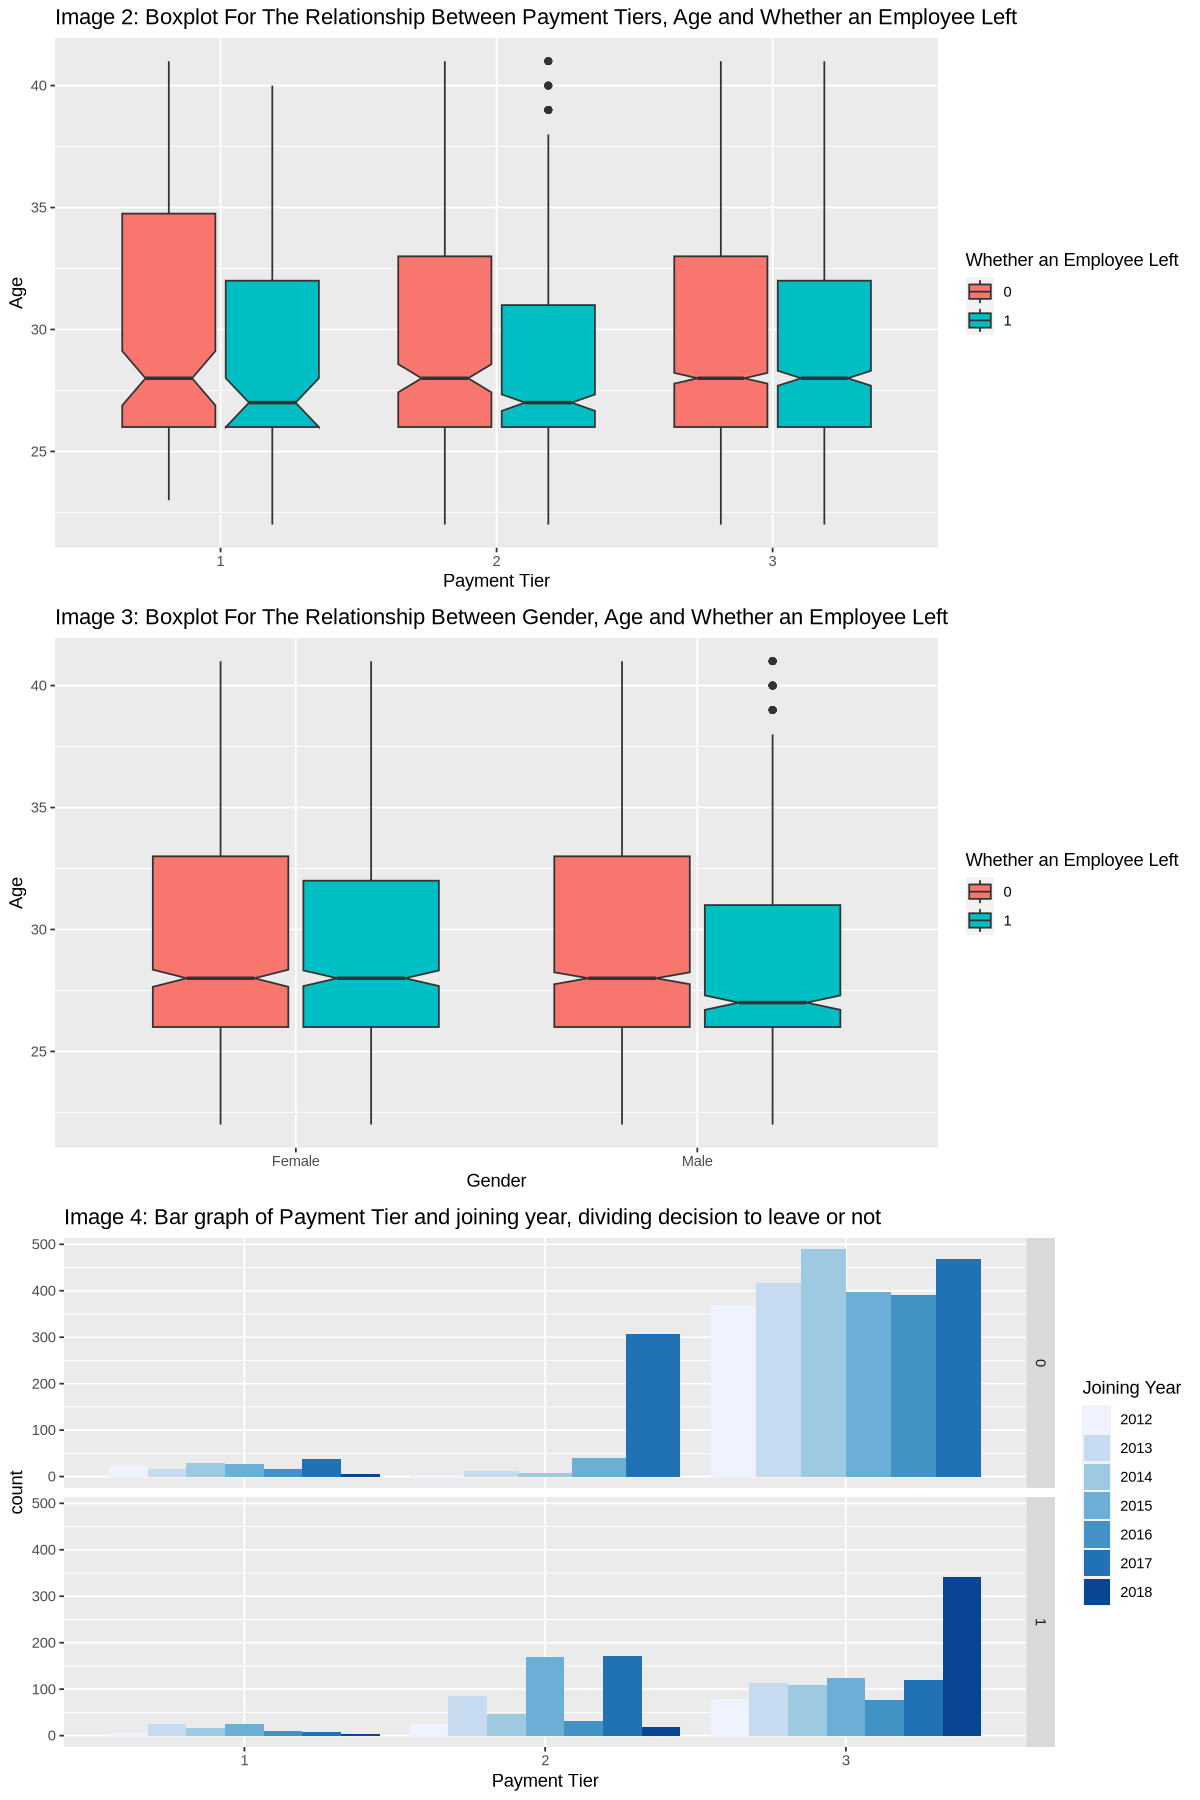

In [148]:
# Setting plot dimensions
options(repr.plot.width=10, repr.plot.height=15)
payment_year <- employee_data_vis %>%
              group_by(PaymentTier, JoiningYear,LeaveOrNot) %>%
              summarize(count = n())%>%
              ggplot(aes(x = as.factor(PaymentTier), y = count, fill = as.factor(JoiningYear))) +
              geom_bar(stat = "identity",position="dodge") +
              labs( x = "Payment Tier",
                    fill = "Joining Year") +
              facet_grid(LeaveOrNot~.)+
              scale_fill_brewer(palette="Blues") +
              ggtitle("Image 4: Bar graph of Payment Tier and joining year, dividing decision to leave or not")

#Boxplot showing the relationship between Payment Tiers, Age and the response LeaveOrNot
agePaymentLeaveBoxplot <- employee_data_vis %>%
    ggplot() + 
    geom_boxplot(aes(x = PaymentTier, y = Age, fill = LeaveOrNot), notch = TRUE) + 
    labs(x = "Payment Tier", y = "Age", fill = "Whether an Employee Left") + 
    ggtitle("Image 2: Boxplot For The Relationship Between Payment Tiers, Age and Whether an Employee Left") 


#Boxplot showing the relationship between Gender, Age and the response LeaveOrNot
ageGenderLeaveBoxplot <- employee_data_vis %>%
    ggplot() + 
    geom_boxplot(aes(x = Gender, y = Age, fill = LeaveOrNot), notch = TRUE) + 
    labs(x = "Gender", y = "Age", fill = "Whether an Employee Left") + 
    ggtitle("Image 3: Boxplot For The Relationship Between Gender, Age and Whether an Employee Left") 


#Displaying both plots
grid_layout <- plot_grid(agePaymentLeaveBoxplot,
                  ageGenderLeaveBoxplot,
                  payment_year, ncol = 1)
grid_layout

**Overall observation**

From Table 2, We can see that there is disproportonately more data points for employee that did not leave. This could cause a problem in the future of this analysis as we may not have enough data on the employees that left.

Meanwhile, Image 1 show us how the response variable changes with each different explanatory variables while keeping the other variables constant. From glancing over Image 1, we might want to explore whether `Gender`,`JoiningYear`,`PaymentTier`, and `Age` can affect whether the Employee decide to leave or not, which lead us to Image 2, 3, and 4. In Image 2, we look further into how `Gender` and `Payment Tier` can affect the retention rate of the company. Across Payment Tier 1 and 2, the median age of people who want to leave the company are younger than ones who don't. Similary affect can be observed for male employee in Image 3. Meanwhile, looking at Image 4, we can see that there are more people who would want to leave in recent joining year of 2018, at a lower payment tier of 2 and 3. Despite the difference in the said observations, we cannot be sure if these variables have a significance effect on the response variabes. And base on our research of the subject, there could be various reason for employee retention rate. Hence, we decided to keep all the variables in the dataset, and we will employ different kind of variable selection, and shrinkage method to ensure that we will get the best fit model.

### Method Plans

#### Logistic Regression Theory
Logistic regression is a supervised machine learning algorithm that accomplishes binary classification tasks by predicting the probability of an outcome, event, or observation. The model delivers a binary or dichotomous outcome limited to two possible outcomes: yes/no, 0/1, or true/false (Chen, 2018).

- Assumptions to be made of the dataset for logistic regression model
    + Binary response: The response variable has to be binary (two possible result) or the sum of those binary responses
    + Independence: The observations must be indepdent from each other
    + Multicollinearity: The explanatory variables should have little to no multicollinearity among each other
    + Linearity: Assumes that there's linearity between the explantory variables and log odds
    + Sample size: A large enough sample size

#### Ridge regression
In ridge regression, we add a penalty by way of a tuning parameter called lambda which is chosen using cross validation. The idea is to make the fit small by making the residual sum or squares small plus adding a shrinkage penalty. The shrinkage penalty is lambda times the sum of squares of the coefficients so coefficients that get too large are penalized. As lambda gets larger, the bias is unchanged but the variance drops (Chen, 2018). The drawback of ridge is that it doesn’t select variables. It includes all of the variables in the final model.

#### Other group members progress
We proposed the idea of each member evaluating a particular approach - Forward, Backward, Lasso and Ridge(starts with keeping all the input variables). Each member of the group would evaluate the predictive performance of the model using a testing set and would compare the various models generated.

#### Forward and Backward model selection to select the variables
Select a reduced LR using the forward selection algorithm using our training set `employee_data_train`. To perform methods, we use `regsubsets()` function from library `leaps`.

Using the `adjR^2` of these 11 models, we can select the best generative model and indicate which input variables are in the selected model. The higher `adjR^2`, the better the model is.

Then, we fit a logistic regression model using the variables chosen by two method selections. Family will be set to binomial since the response variable is a binary - 1 or 0. Compare the ROC curve for each method and choose the highest one as the predictive model.

#### Ridge Regression and LASSO regression
Perform coefficients estimation using ridge and lasso regressions to fit a logistic regression useful for predictive modeling. We find the optimum value for  λ that provides the largest average AUC in two regression model with this object.

Use `plot()` to visualize the resulting cross-validation AUCs for each value of  λ. The resulting plot will indicate the average AUC (red dot) and error bars (in grey) on the y-axis along with the λ sequence on the  x-axis in log-scale.

Once we have the optimum value for λ, let us fit the two regression model and we will compare versus the ordinary logistic model(CV AUC).

Compare the AUC computed by CV for four models. From the ROC curve in the test set, the Ridge model performs best. It shows that the AUC of the Ridge model is about 0.74 (means there is a 70% chance that the model will be able to distinguish between positive class and negative class), which is the highest one.

Therefore, we will use the Ridge model as the predictive model. Apply this model on testing data.

### Implementation and Results

First we will set seed in order for the splitting of the dataset is consistent if this method is going to replicate in the future. Then, we will split the dataset into 70/30 for training and testing respectively. We will split the data using stratied sampling with `LeaveOrNot` variables, since from Table 2, we can see that the number of employee wanting to leave is much less than the number of employee not wanting to leave, so we want to keep the same proportion in both test set and training set

In [149]:
# Setting Seed
set.seed(1234) 

employee_split <- initial_split(employee_data, prop = 0.7, strata = LeaveOrNot)
employee_data_train <- training(employee_split)
employee_data_test <- testing(employee_split)

head(employee_data_train)
tail(employee_data_train)
nrow(employee_data_train)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Bachelors,2015,New Delhi,3,38,Male,No,0,0
Bachelors,2016,Pune,3,23,Male,No,1,0
Masters,2017,New Delhi,2,37,Male,No,2,0
Bachelors,2016,Pune,3,34,Male,No,3,0
Bachelors,2016,Bangalore,3,39,Male,No,2,0


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2018,Bangalore,3,32,Male,Yes,1,1
Bachelors,2018,Bangalore,3,31,Female,No,2,1
Bachelors,2018,Bangalore,3,32,Male,Yes,2,1
Bachelors,2016,Bangalore,1,33,Female,No,0,1
Masters,2013,Pune,2,37,Male,No,2,1
Masters,2018,New Delhi,3,27,Male,No,5,1


[1] 3257

The only type of value that the `glmnet` take are matrices. Therefore, we need to prepare a model matrix from the training dataset for `glmnet`

In [150]:
model_matrix_X_train <- model.matrix(object = LeaveOrNot ~ .,
                                     data = employee_data_train)[, -1]
matrix_Y_train <-
     as.matrix(employee_data_train%>%dplyr::select(LeaveOrNot), ncol = 1)

Once we have prepare our training dataset to fit for the `glmnet` functions, we will now find the $\lambda$ value in the Ridge regression that will give us the largest Area Under Curve (AUC) using the cross-validation method. We decide to go with fold of 10 for the cross-validation method. This step can easily be done with `cv.glmnet` function.

In [151]:
# Find the value of 𝜆
set.seed(1234)
Employee_cv_lambda_ridge <-
   cv.glmnet(
        x = model_matrix_X_train,
        y = matrix_Y_train,
        alpha = 0,
        family = "binomial",
        type.measure = "auc",
        nfolds = 10)
Employee_cv_lambda_ridge


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure       SE Nonzero
min   0.01    97  0.7337 0.008751      10
1se  92.62     2  0.7253 0.008226      10

Table 3: The best lambda value and the the highest lambda value within 1 SE of the highest AUC

We can see that $\hat{\lambda}_{min}$ that will give us the largest average AUC out of all possible $\lambda$ is 0.0108. While $\hat{\lambda}_{1SE}$ is the highest $\lambda$ in which the average AUC is within 1 standard deviation of the maximum

Using `plot` we will visualize the resulting cross-validation AUCs for each value of  𝜆

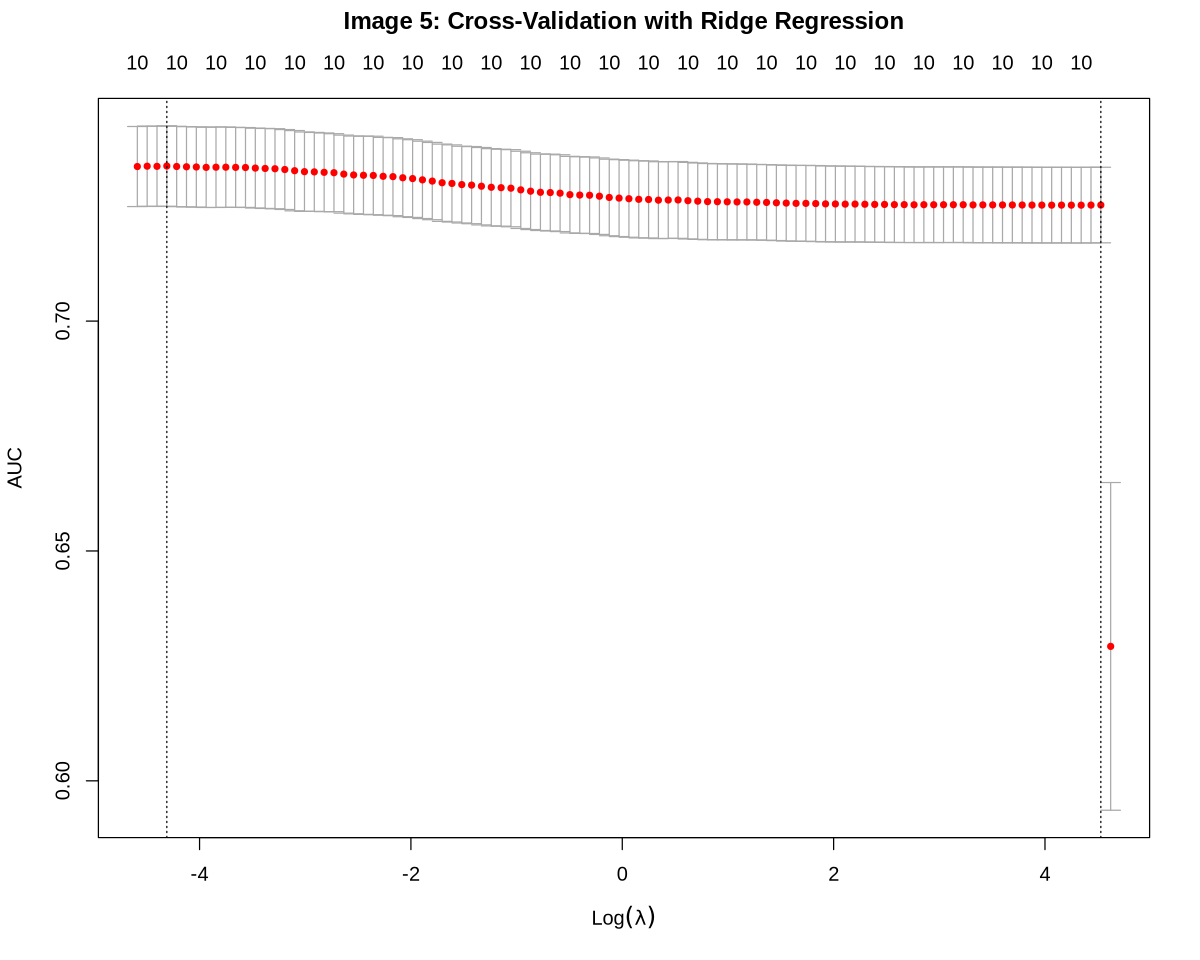

In [152]:
options(repr.plot.width=10, repr.plot.height=8)
plot(Employee_cv_lambda_ridge,
             main = "Image 5: Cross-Validation with Ridge Regression\n\n")

The resulting Image 5 indicate the average AUC on the y-axis, while the $\lambda$ in log-scale is indicate in the below x-axis. And the top x-axis indicate that all 10 input gives use estimated coefficients different from 0 by each value of $\lambda$ since Ridge Regression never shrink the coeffcient to 0. The first dotted line in Image 5 indicate to use $\hat{\lambda}_{min}$ that will give us the highest average AUC value. That average AUC value from the table seem to be above 0.70. While the second dotted line in Image 5 indicate to us that $\hat{\lambda}_{1SE}$

Now let us see the estimated coefficients across all lambda range

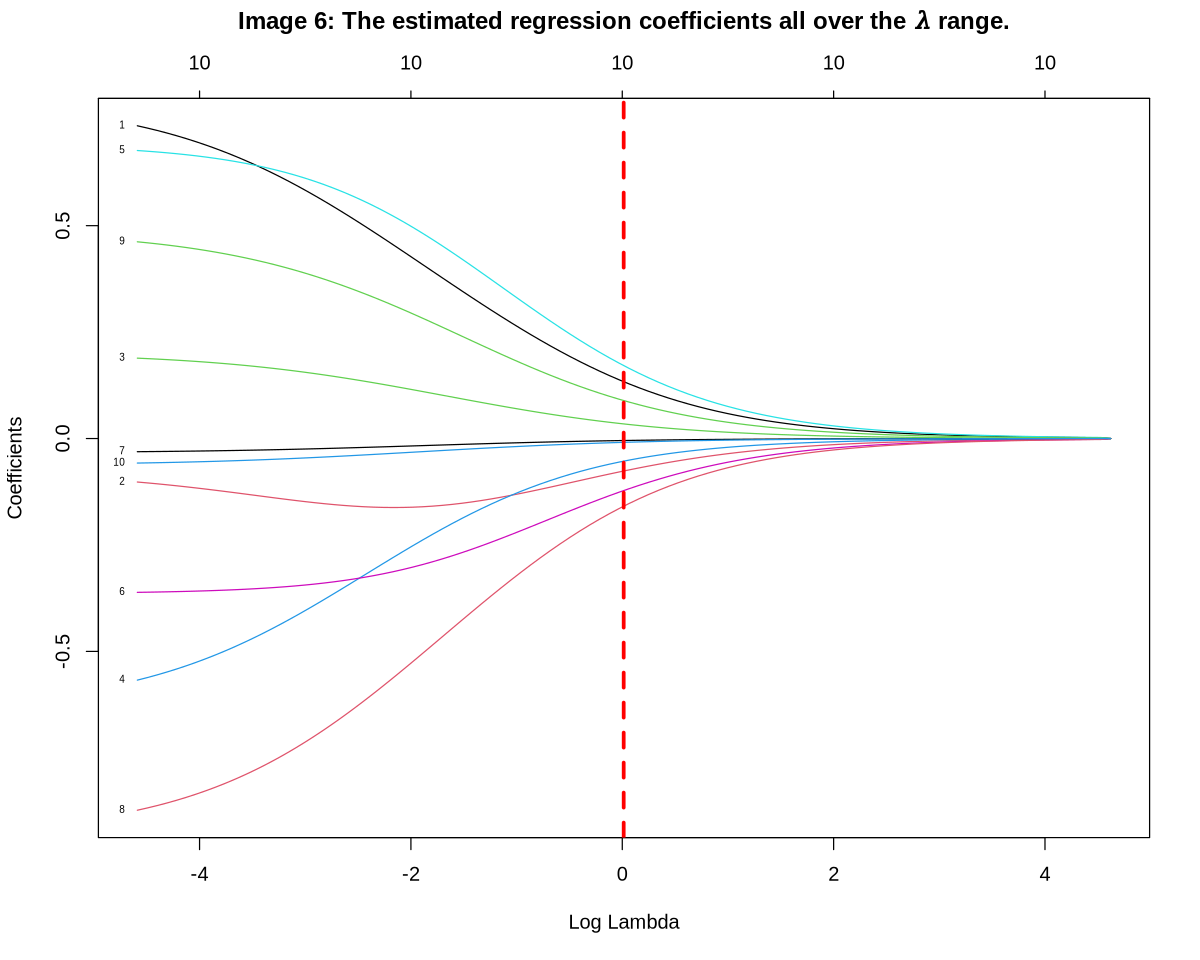

In [153]:
bestlam <- Employee_cv_lambda_ridge$lambda.min

plot(Employee_cv_lambda_ridge$glmnet.fit, "lambda",label = T, main = "Image 6: The estimated regression coefficients all over the 𝜆 range.\n\n")
abline(v = bestlam, col = "red", lwd = 3, lty = 2)

We can see from Image 6, once the we pass over the $\lambda$ that give us the highest average AUC on the log-scale that is indicated using the dotted red line, the estimated coefficients start to shrink to near 0

Once we have the best lambda, we will now fit the ridge regression model

In [154]:
### Fit the ridge regression model 
Employee_ridge_max_AUC <-
  glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 0,
  family = 'binomial',
  lambda = bestlam
)
coef(Employee_ridge_max_AUC)

11 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -371.97709621
EducationMasters             0.71768065
EducationPHD                -0.10859269
JoiningYear                  0.18538222
CityNew Delhi               -0.54850189
CityPune                     0.67114006
PaymentTier                 -0.36006237
Age                         -0.03024898
GenderMale                  -0.85613252
EverBenchedYes               0.45461415
ExperienceInCurrentDomain   -0.05632135

Table 4: The estimated coefficient using ridge regression

After we have the model that we wanted. We will use that model to predict using the test set, and compute the AUC model. Finally visualize the ROC curve to see how well our Ridge regression model built using the training set fit the test set

Setting levels: control = 0, case = 1

Warning message in roc.default(response = employee_data_test$LeaveOrNot, predictor = predict(Employee_ridge_max_AUC, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases




Call:
roc.default(response = employee_data_test$LeaveOrNot, predictor = predict(Employee_ridge_max_AUC,     newx = model_matrix_X_test))

Data: predict(Employee_ridge_max_AUC, newx = model_matrix_X_test) in 916 controls (employee_data_test$LeaveOrNot 0) < 480 cases (employee_data_test$LeaveOrNot 1).
Area under the curve: 0.7333

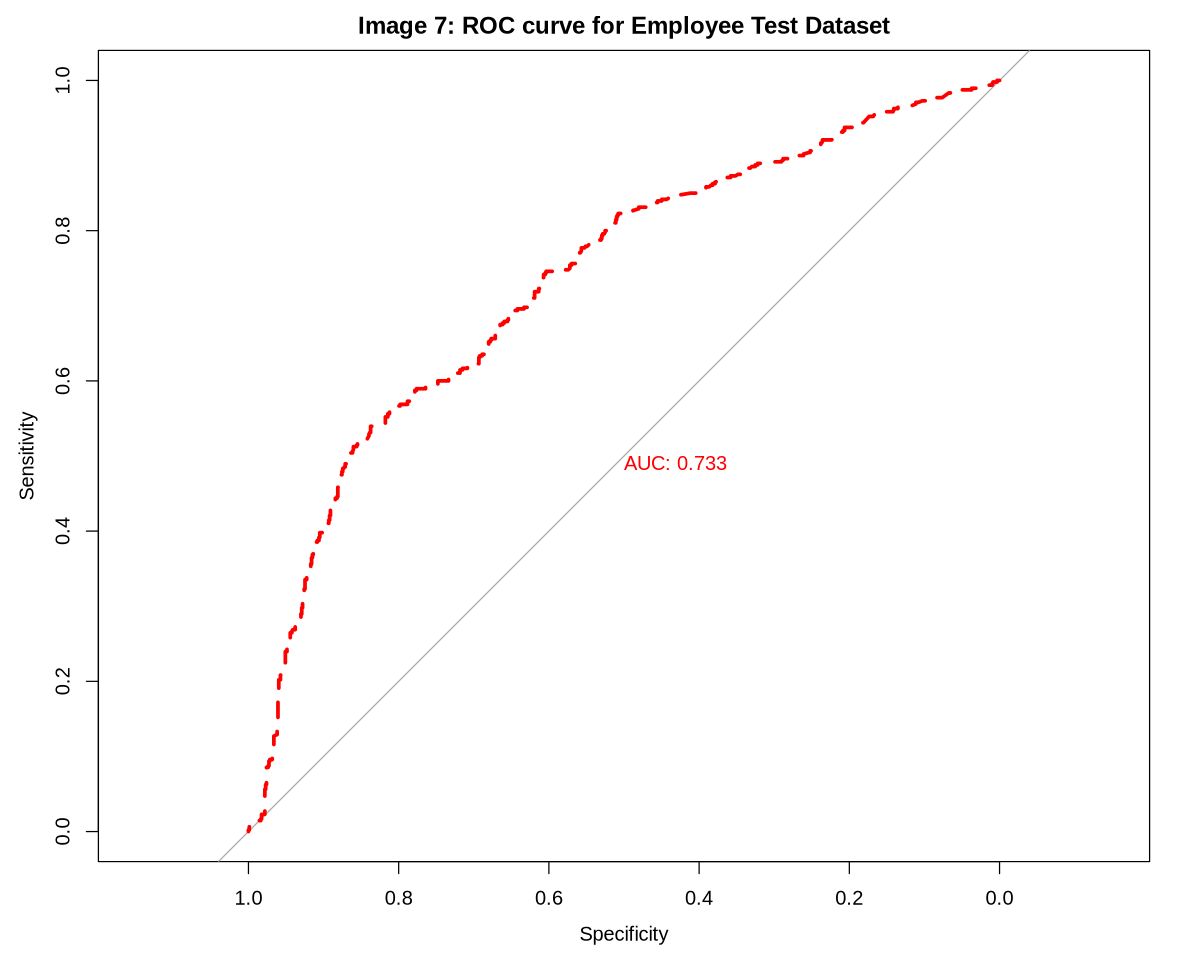

In [157]:
# Obtaining the ROC curve ridge model on the testing dataset
set.seed(1234)

#Prepare the test set for fitting
model_matrix_X_test <- model.matrix(object = LeaveOrNot ~ .,
                                     data = employee_data_test)[, -1]

Employee_test_roc <- 
    roc(
        response = employee_data_test$LeaveOrNot,
        predictor = predict(Employee_ridge_max_AUC,
                           newx= model_matrix_X_test)
        )
Employee_test_roc

options(repr.plot.width=10, repr.plot.height=8)
plot(Employee_test_roc,
     print.auc = TRUE, lwd = 3, lty = 2, col = "red",
     main = "Image 7: ROC curve for Employee Test Dataset")

## Discussion

Our analysis utilized a logistic regression model with ridge regression to predict employee turnover based the following variables: `Education`, `JoiningYear`, `City`, `PaymentTier`, `Age`, `Gender`, `EverBenched`, and `ExperienceInCurrentDomain`. The model's predictive power was measured using the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC). An AUC of 1 represents a perfect classification while 0.5 represents a model with no discriminatory power. The AUC of our model was found to be 0.733. This AUC value indicates that although the model has a moderately good discriminatory power, there is still room for improvement since the AUC is still somewhat far from 1. 

The implications of these findings are varied. For HR, the model can help identify factors linked to employee turnover, which in turn can help them create plans for employee retention. For employees, the model could aid in assessing the risk of turnover within a firm, allowing them to better choose their employment firm.

Our expectation was to train a strong model that can accurately predict employee turnover. Although the AUC obtained indicates that the model we made was useful, there is room for improvement as it falls short of previous predictive studies where the AUC reached 0.842 (Jin et al., 2020).

A few of the limitations that ridge model selection has is that it assumes a linear relationship between the predictors and the dependent variable. It is also sensitive to the scale of the predictor variables and can introduce bias in the coefficient estimates, especially when the penalty term is too strong. Finally, the effectiveness of Ridge regression depends on selecting an optimal regularization parameter.

There are several approaches to improving the model. Firstly, additional variables could be considered in order to identify more complex interactions. Secondly, more observations could be added to refine the model. Thirdly, more sophisticated models, such as random forests, could be used to capture nonlinear relationships and interactions between variables more effectively. Lastly, the model could be tested on different datasets worldwide to assess and improve its generalisability.

Some future research questions this study could lead to would be:
- How do educational qualifications beyond a bachelor's degree, such as a master's or Ph.D., influence an employee’s decision to stay or leave a company?
- How does the salary tier within a company affect employee turnover, and what other compensation-related factors might influence this relationship?
- Does age have a linear relationship with employee turnover, or are there specific age ranges where the likelihood to leave is significantly higher or lower?

In conclusion, although our logistic regression model is useful in the preliminary identification of employees at risk of leaving, it is clear that additional research and model refinement is necessary to provide more insight in the matter.

## References

### Dataset:
Employee dataset [Obtained from Kaggle] 
https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset/data


### Literature:
Chatzipetrou, P., Šmite, D., & Van Solingen, R. (2018, October). When and who leaves matters: emerging results from an empirical study of employee turnover. In Proceedings of the 12th ACM/IEEE International Symposium on Empirical Software Engineering and Measurement (pp. 1-4).
https://doi.org/10.1145/3239235.3267431

Chen, Zhe(2018). Dynamic Neuroscience Statistics, Modeling, and Control. Springer International Publishing, 3-030-10139-8, 978-3-030-10139-8

Hom, P. W., Allen, D. G., & Griffeth, R. W. (2019). Employee retention and turnover: Why employees stay or leave. Routledge.
https://doi.org/10.4324/9781315145587

Khatri, N., Fern, C. T., & Budhwar, P. (2001). Explaining employee turnover in an Asian context. Human Resource Management Journal, 11(1), 54-74.
https://doi.org/10.1111/j.1748-8583.2001.tb00032.x

Jin, Z., Shang, J., Zhu, Q., Ling, C., Xie, W., & Qiang, B. (2020a). RFRSF: Employee
turnover prediction based on random forests and survival analysis. Web Information
Systems Engineering – WISE 2020, 503–515.
https://doi.org/10.1007/978-3-030-62008-0_35

Mobley, W. H. (1982). Employee Turnover: Causes, Consequences, and Control. Reading, MA: Addison-Wesley.
https://lccn.loc.gov/81020485